In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
import scipy.special as sf
from scipy.stats import norm

In [2]:
dt = 0.1
D = 1.0
L = 10
#xl = 5.0
#xr = 6.0
N = 10
length = 10000

In [7]:
# adopted from https://stackoverflow.com/questions/12418234/logarithmically-spaced-integers
def gen_log_space(limit, n):
    result = [1]
    if n>1:  # just a check to avoid ZeroDivisionError
        ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    while len(result)<n:
        next_value = result[-1]*ratio
        if next_value - result[-1] >= 1:
            # safe zone. next_value will be a different integer
            result.append(next_value)
        else:
            # problem! same integer. we need to find next_value by artificially incrementing previous value
            result.append(result[-1]+1)
            # recalculate the ratio so that the remaining values will scale correctly
            ratio = (float(limit)/result[-1]) ** (1.0/(n-len(result)))
    # round, re-adjust to 0 indexing (i.e. minus 1) and return np.uint64 array
    return np.array(list(map(lambda x: round(x)-1, result)), dtype=np.uint64)

In [20]:
logindex=gen_log_space(1000,100)
print(logindex)

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  25  26  27  29  30  32  33  35  37  39  41  43
  45  47  50  52  55  58  61  64  67  70  74  78  82  86  90  95  99 104
 110 115 121 127 134 140 148 155 163 171 180 189 198 208 219 230 241 253
 266 279 293 308 324 340 357 375 394 414 434 456 479 503 529 555 583 612
 643 675 709 745 782 821 863 906 951 999]


In [12]:
# this is the more realistic model with periodic boundary conditions -L,L
def corrfitPB(t,N,D,w0,L):
    nmax = 20
    n = np.arange(1,nmax)
    nn,tt = np.meshgrid(n,t)
    
    efa = nn*np.pi*w0**2*1j
    an = np.exp(-nn**2*np.pi**2*w0**2/2/L**2)*(sf.erf((L**2-efa)/np.sqrt(2)/L/w0)+sf.erf((L**2+efa)/np.sqrt(2)/L/w0))
    an = np.absolute(an)**2*np.exp(-D*nn**2*np.pi**2*tt/L**2)
    return np.sum(an,axis=1)/N/2

corrfitPB_model=lm.Model(corrfitPB)

In [13]:
N_list=[]
D_list=[]
dN_list=[]
dD_list=[]
Nlg_list=[]
Dlg_list=[]
dNlg_list=[]
dDlg_list=[]
for i in range(100):
    intensity = np.load("data/dt01_N10000_"+str(i)+".npy")
    # calculate autocorrelation function
    f = np.fft.rfft(intensity)
    acf = np.fft.irfft(f * np.conjugate(f))
    acf = np.fft.fftshift(acf) / length
    autocorr = acf[int(length/2):]/intensity.mean()**2

    autocorr = autocorr[:1000]-1.0
    t = np.arange(0,autocorr.size)*dt
    
    paramsPB = corrfitPB_model.make_params()
    paramsPB['w0'].set(value=1,vary=False)
    paramsPB['N'].set(value=N*0.8,vary=True)
    paramsPB['D'].set(value=D*0.8,vary=True)
    paramsPB['L'].set(value=L,vary=False)

    resultPB = corrfitPB_model.fit(t=t,data=autocorr,params=paramsPB)
    
    N_list.append(resultPB.values['N'])
    D_list.append(resultPB.values['D'])
    dN_list.append(resultPB.covar[0][0])
    dD_list.append(resultPB.covar[1][1])
    
    print(resultPB.fit_report())
    
    # now do the same analysis in an autocorrelation function spaced in log-space
    autocorr_lg = autocorr[logindex]
    t_lg = logindex*dt
    
    paramsPBlg = corrfitPB_model.make_params()
    paramsPBlg['w0'].set(value=1,vary=False)
    paramsPBlg['N'].set(value=N*0.8,vary=True)
    paramsPBlg['D'].set(value=D*0.8,vary=True)
    paramsPBlg['L'].set(value=L,vary=False)

    resultPBlg = corrfitPB_model.fit(t=t_lg,data=autocorr_lg,params=paramsPBlg)
    
    Nlg_list.append(resultPBlg.values['N'])
    Dlg_list.append(resultPBlg.values['D'])
    dNlg_list.append(resultPBlg.covar[0][0])
    dDlg_list.append(resultPBlg.covar[1][1])
    
    print(resultPBlg.fit_report())
   

[[Model]]
    Model(corrfitPB)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 1000
    # variables        = 2
    chi-square         = 0.861
    reduced chi-square = 0.001
    Akaike info crit   = -7050.989
    Bayesian info crit = -7041.174
[[Variables]]
    N:    8.59638700 +/- 0.182854 (2.13%) (init= 8)
    D:    1.06573011 +/- 0.036301 (3.41%) (init= 0.8)
    w0:   1 (fixed)
    L:    10 (fixed)
[[Correlations]] (unreported correlations are <  0.100)
    C(N, D)                      = -0.775 

[[Model]]
    Model(corrfitPB)
[[Fit Statistics]]
    # function evals   = 15
    # data points      = 100
    # variables        = 2
    chi-square         = 0.037
    reduced chi-square = 0.000
    Akaike info crit   = -784.573
    Bayesian info crit = -779.363
[[Variables]]
    N:    9.03784065 +/- 0.154780 (1.71%) (init= 8)
    D:    0.94788130 +/- 0.037903 (4.00%) (init= 0.8)
    w0:   1 (fixed)
    L:    10 (fixed)
[[Correlations]] (unreported correlations are <

In [14]:
N_list=np.array(N_list)
D_list=np.array(D_list)
dN_list=np.sqrt(np.array(dN_list))
dD_list=np.sqrt(np.array(dD_list))

Nlg_list=np.array(Nlg_list)
Dlg_list=np.array(Dlg_list)
dNlg_list=np.sqrt(np.array(dNlg_list))
dDlg_list=np.sqrt(np.array(dDlg_list))

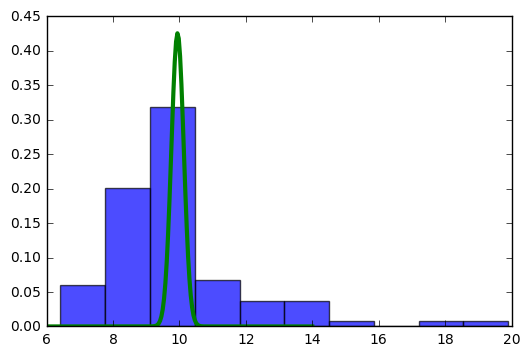

In [26]:
fitnormN=norm(loc=N_list.mean(),scale=dN_list.mean())
fitn = np.linspace(6,14,200)
plt.figure()
plt.hist(N_list,normed=True,alpha=0.7)
plt.plot(fitn,fitnormN.pdf(fitn)/5,linewidth=3)

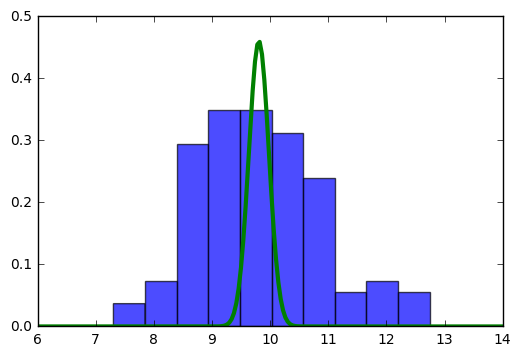

In [27]:
fitnormNlg=norm(loc=Nlg_list.mean(),scale=dNlg_list.mean())
fitn = np.linspace(6,14,200)
plt.figure()
plt.hist(Nlg_list,normed=True,alpha=0.7)
plt.plot(fitn,fitnormNlg.pdf(fitn)/5,linewidth=3)

In [16]:
print(N_list.mean(),N_list.std(),dN_list.mean())
print(Nlg_list.mean(),Nlg_list.std(),dNlg_list.mean())

9.94443061119 2.04691396174 0.187438716729
9.80579433534 1.05599742457 0.17335589917


In [21]:
print(D_list.mean(),D_list.std(),dD_list.mean())
print(Dlg_list.mean(),Dlg_list.std(),dDlg_list.mean())

1.15302182558 0.407699797648 0.0357961157368
1.09776078747 0.262481065564 0.0443565877217


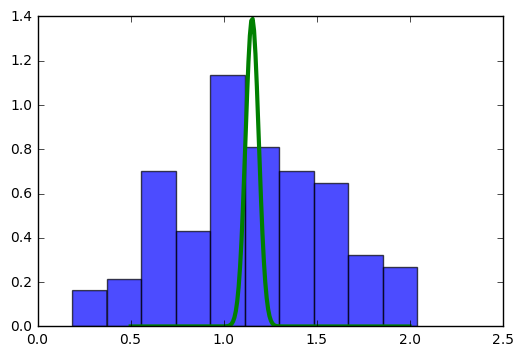

In [34]:
fitnormD=norm(loc=D_list.mean(),scale=dD_list.mean())
fitd = np.linspace(0.5,2,200)
plt.figure()
plt.hist(D_list,normed=True,alpha=0.7)
plt.plot(fitd,fitnormD.pdf(fitd)/8,linewidth=3)

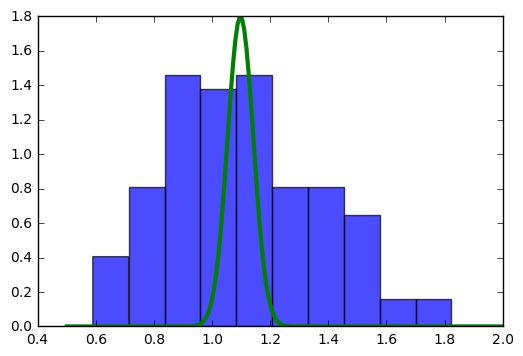

In [33]:
fitnormDlg=norm(loc=Dlg_list.mean(),scale=dDlg_list.mean())
fitd = np.linspace(0.5,2,200)
plt.figure()
plt.hist(Dlg_list,normed=True,alpha=0.7)
plt.plot(fitd,fitnormDlg.pdf(fitd)/5,linewidth=3)